In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import pipeline
!apt-get update -qq
!apt-get install -y openjdk-17-jdk
!pip install textstat
!pip install --quiet language_tool_python==2.9.4
import textstat
import language_tool_python
import re

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jdk is already the newest version (17.0.16+8~us1-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [37]:
# Google Sheet file ID
file_id = "1mZfb1Q9C0gBQ26MZGgv61J_ijGOno60d"

# Export as Excel (.xlsx)
url = f"https://docs.google.com/spreadsheets/d/{file_id}/export?format=xlsx"

df = pd.read_excel(url)

print(df.head())

         locationName            category   reviewerName      publishedAtDate  \
0  Gardens by the Bay  Tourist attraction  Stylusmaestro  2021-12-29 10:13:13   
1  Gardens by the Bay  Tourist attraction      JoJo Chin  2020-03-21 09:06:31   
2  Gardens by the Bay  Tourist attraction     Theticus _  2020-03-03 00:12:25   
3  Gardens by the Bay  Tourist attraction        sky wda  2020-01-02 18:05:38   
4  Gardens by the Bay  Tourist attraction    Trúc Nguyễn  2020-01-01 12:22:38   

   rating                                         reviewText  \
0     0.5  For a weekday this is considered very crowded....   
1     1.0  Awsome view with breeze wind. Suitable for all...   
2     0.5  Great place to hang out and have picnic especi...   
3     1.0  Every years great place to catch firework on S...   
4     1.0        This is the 10 times I come here. Best view   

                                           imageUrls  reviewerNumberOfReviews  \
0  https://lh3.googleusercontent.com/geougc-cs/

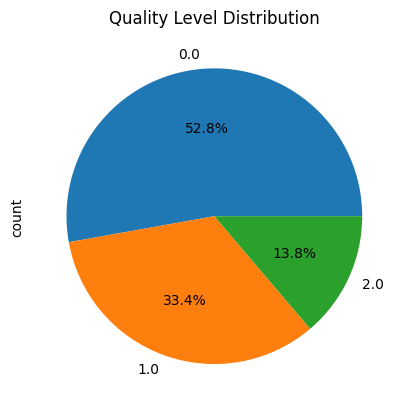

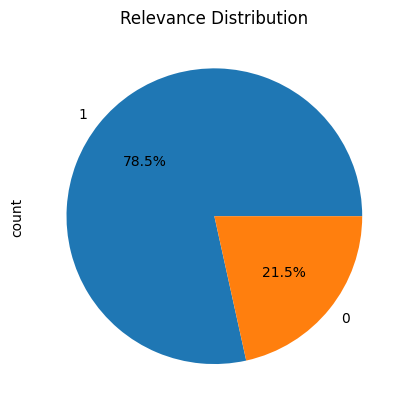

In [38]:
df["qualityLevel"].value_counts().plot(kind="pie", autopct="%1.1f%%", title="Quality Level Distribution")
plt.show()

df["isRelevant"].value_counts().plot(kind="pie", autopct="%1.1f%%", title="Relevance Distribution")
plt.show()

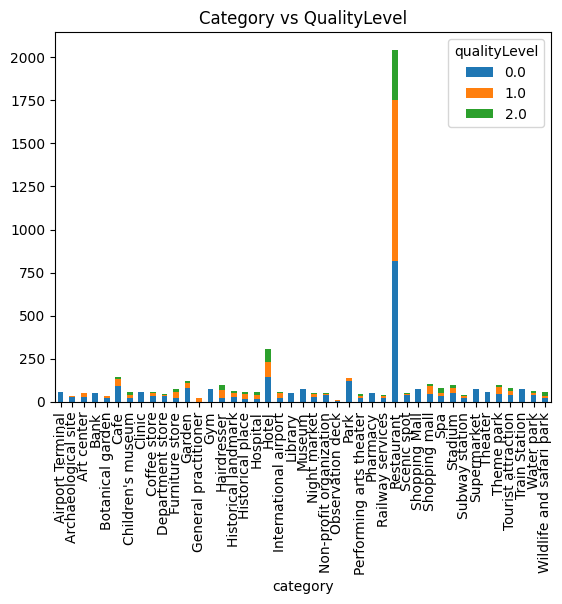

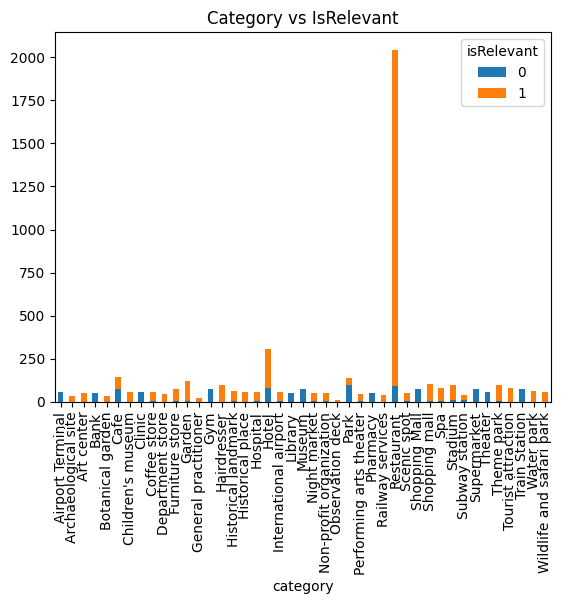

In [39]:
# category vs qualityLevel
pd.crosstab(df["category"], df["qualityLevel"]).plot(kind="bar", stacked=True)
plt.title("Category vs QualityLevel")
plt.show()

# category vs isRelevant
pd.crosstab(df["category"], df["isRelevant"]).plot(kind="bar", stacked=True)
plt.title("Category vs IsRelevant")
plt.show()

In [40]:
df["reviewWordCount"] = df["reviewText"].str.split().apply(len)

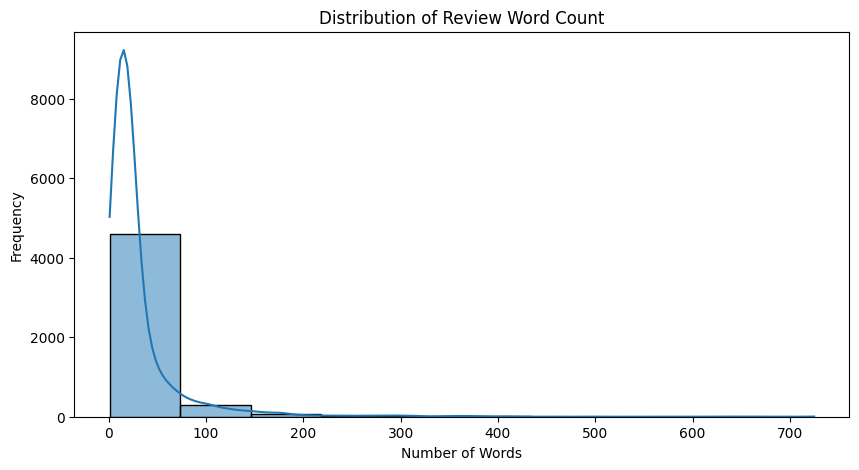

In [43]:
plt.figure(figsize=(10,5))
sns.histplot(df["reviewWordCount"], bins=10, kde=True)
plt.title("Distribution of Review Word Count")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [42]:
# Load pretrained sentiment model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    framework="pt"
)

# Function to map sentiment to 1–5 scale
def sentiment_to_0_1(text):
    try:
        result = sentiment_pipeline(text[:512])[0]  # limit text length
        label = result['label']
        score = result['score']

        if label == "NEGATIVE":
            sentiment_score = 0.0 + (1 - score) * 0.5   # 0 to 0.5
        else:  # POSITIVE
            sentiment_score = 0.5 + score * 0.5        # 0.5 to 1.0
        return sentiment_score
    except:
        return None

df["sentimentScore"] = df["reviewText"].apply(sentiment_to_0_1)
df["sentimentRatingDiff"] = abs(df["sentimentScore"] - df["rating"])

Device set to use cpu


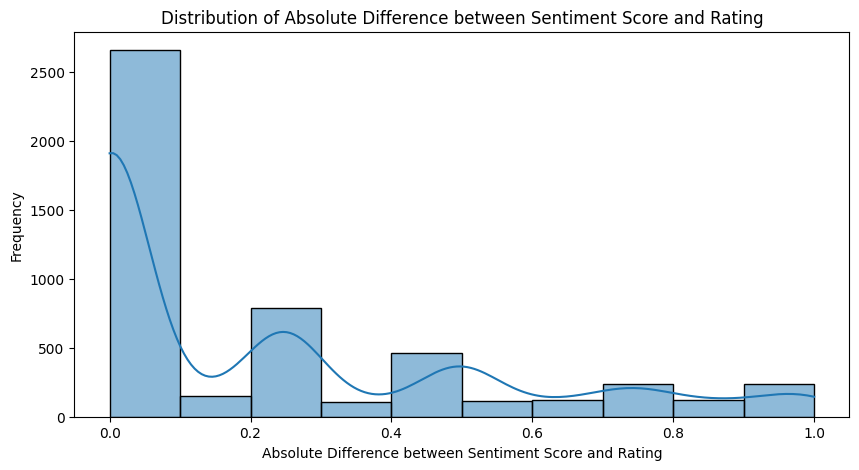

In [44]:
plt.figure(figsize=(10,5))
sns.histplot(df["sentimentRatingDiff"], bins=10, kde=True)
plt.title("Distribution of Absolute Difference between Sentiment Score and Rating")
plt.xlabel("Absolute Difference between Sentiment Score and Rating")
plt.ylabel("Frequency")
plt.show()

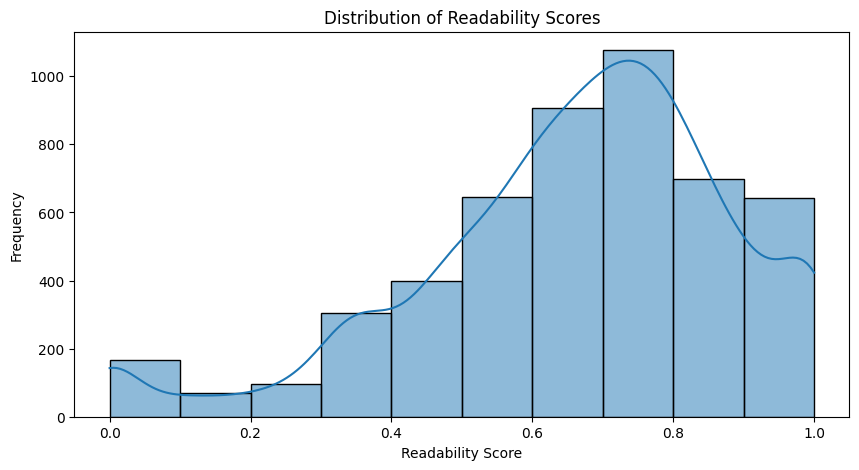

In [45]:
# Readability (scaled 0–1)
def readability_score(text):
    score = textstat.flesch_reading_ease(text)
    # Flesch scores usually between 0–100 (can go outside)
    # Scale to 0–1
    return max(0, min(1, score / 100))

df["readabilityScore"] = df["reviewText"].apply(readability_score)

plt.figure(figsize=(10,5))
sns.histplot(df["readabilityScore"], bins=10, kde=True)
plt.title("Distribution of Readability Scores")
plt.xlabel("Readability Score")
plt.ylabel("Frequency")
plt.show()

In [47]:
# Grammar/Spelling quality (scaled 0–1)
tool = language_tool_python.LanguageTool('en-US')

def grammar_spelling_score(text):
    matches = tool.check(text)  # grammar/spelling issues
    num_errors = len(matches)
    num_words = len(text.split())
    if num_words == 0:
        return 0
    error_rate = num_errors / num_words
    # Convert to quality score (1 = perfect, 0 = terrible)
    return max(0, 1 - error_rate)

df["grammarSpellingScore"] = df["reviewText"].apply(grammar_spelling_score)

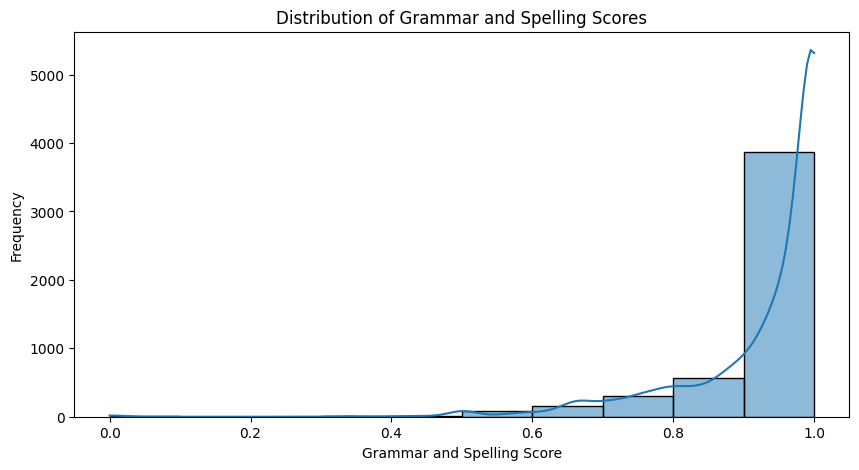

In [48]:
plt.figure(figsize=(10,5))
sns.histplot(df["grammarSpellingScore"], bins=10, kde=True)
plt.title("Distribution of Grammar and Spelling Scores")
plt.xlabel("Grammar and Spelling Score")
plt.ylabel("Frequency")
plt.show()

In [55]:
url_pattern = r'(https?:\s*//\s*\S+|www\.\S+|\S+\.(com|org|net|io|co|edu|gov)(\S*)?)'

def contains_link(text):
    if pd.isna(text):
        return 0
    return 1 if re.search(url_pattern, text, flags=re.IGNORECASE) else 0

df["hasLink"] = df["reviewText"].apply(contains_link)

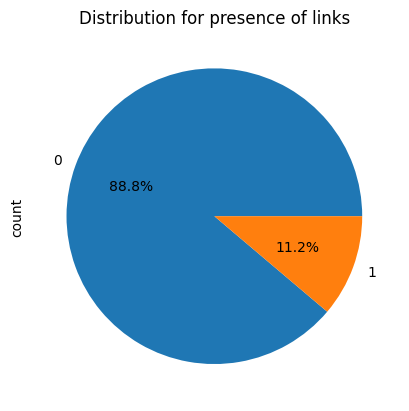

In [56]:
df["hasLink"].value_counts().plot(kind="pie", autopct="%1.1f%%", title="Distribution for presence of links")
plt.show()

In [57]:
df.head(10)

,locationName,category,reviewerName,publishedAtDate,rating,reviewText,imageUrls,reviewerNumberOfReviews,temporarilyClosed,qualityLevel,isRelevant,reviewWordCount,sentimentScore,sentimentRatingDiff,readabilityScore,grammarSpellingScore,hasLink
0,Gardens by the Bay,Tourist attraction,Stylusmaestro,2021-12-29 10:13:13,0.5,For a weekday this is considered very crowded....,https://lh3.googleusercontent.com/geougc-cs/AB...,49.0,0.0,2.0,1,32,0.001126,0.498874,0.771025,1.000000,0
1,Gardens by the Bay,Tourist attraction,JoJo Chin,2020-03-21 09:06:31,1.0,Awsome view with breeze wind. Suitable for all...,NaN,201.0,0.0,1.0,1,11,0.999089,0.000911,0.705070,0.909091,0
2,Gardens by the Bay,Tourist attraction,Theticus _,2020-03-03 00:12:25,0.5,Great place to hang out and have picnic especi...,https://lh3.googleusercontent.com/geougc-cs/AB...,2181.0,0.0,1.0,1,12,0.999921,0.499921,0.818550,0.916667,0
3,Gardens by the Bay,Tourist attraction,sky wda,2020-01-02 18:05:38,1.0,Every years great place to catch firework on S...,https://lh3.googleusercontent.com/geougc-cs/AB...,53.0,0.0,2.0,1,28,0.999850,0.000150,0.355107,0.892857,0
4,Gardens by the Bay,Tourist attraction,Trúc Nguyễn,2020-01-01 12:22:38,1.0,This is the 10 times I come here. Best view,https://lh3.googleusercontent.com/geougc-cs/AB...,127.0,0.0,0.0,1,10,0.997996,0.002004,1.000000,1.000000,0
5,Gardens by the Bay,Tourist attraction,Derek Ng,2019-09-10 05:55:15,1.0,Marina Barrage has a nice park connector that ...,NaN,4.0,0.0,2.0,1,21,0.999833,0.000167,0.632346,1.000000,0
6,Gardens by the Bay,Tourist attraction,KJ Yaw,2019-05-15 10:23:21,1.0,Cannot imagine that this place was still sea a...,https://lh3.googleusercontent.com/geougc-cs/AB...,341.0,0.0,2.0,1,83,0.999858,0.000142,0.668562,0.951807,0
7,Gardens by the Bay,Tourist attraction,Abdullah Ibrahim,2019-05-02 08:21:43,0.5,Very nice place with a big open and spacious a...,NaN,100.0,0.0,2.0,1,63,0.998019,0.498019,0.700343,0.984127,0
8,Gardens by the Bay,Tourist attraction,Ái Việt Nguyễn,2019-03-07 03:45:04,1.0,"Century building, beautiful view",NaN,438.0,0.0,0.0,1,4,0.999932,0.000068,0.124250,1.000000,0
9,Gardens by the Bay,Tourist attraction,Joni Wang,2019-01-13 01:41:39,1.0,Good place for groups and family. It has an ou...,NaN,110.0,0.0,2.0,1,24,0.999848,0.000152,0.677550,1.000000,0


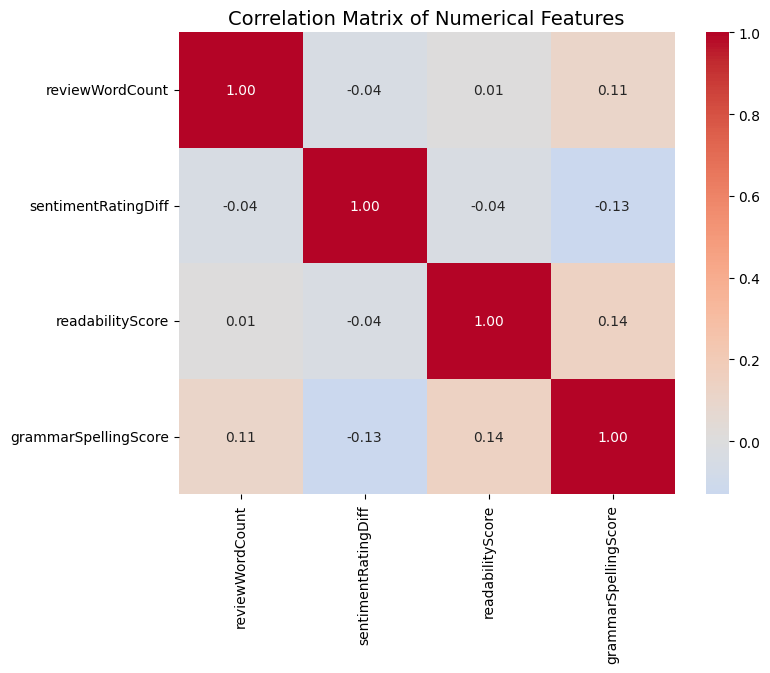

In [58]:
numerical_variables = ["reviewWordCount", "sentimentRatingDiff", "readabilityScore", "grammarSpellingScore"]
numerical_df = df[numerical_variables]
corr = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Matrix of Numerical Features", fontsize=14)
plt.show()